<a href="https://colab.research.google.com/github/lsilva18/EvolutionaryComputation/blob/main/List04Ex03_NonlinearOptimization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Instalar pacote DEAP e importar o que for necessário

In [ ]:
# https://deap.readthedocs.io/en/master/
!pip install deap

In [ ]:
# Bibliotecas a serem utilizadas
import random
import numpy as np
import matplotlib.pyplot  as plt
from deap import algorithms, base
from deap import creator, tools

## O problema - restrições com restrições não lineares 

Um problema muito usual na área de negócios é o de localização de Fábricas, Armazéns, Centros de distribuição e torres de transmissão telefônica. Nesses problemas devemos Minimizar a distância total entre os centros consumidores e o centro de distribuição, reduzindo assim teoricamente o custo de transporte ou perdas de transmissão. O usual é se colocar um eixo cartesiano sobre um mapa e determinar a posição dos centros consumidores em relação a uma origem aleatória.

O Gerente de Projetos da LCL Telefonia Celular S.A. tem que localizar uma antena de retransmissão para atender a três localidades na Baixada Fluminense. Por problemas técnicos a antena não pode estar a mais de 10 km do centro de cada cidade. Considerando as localizações relativas abaixo, determine o melhor posicionamento para a torre.

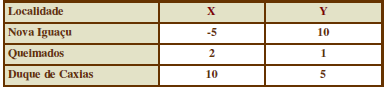

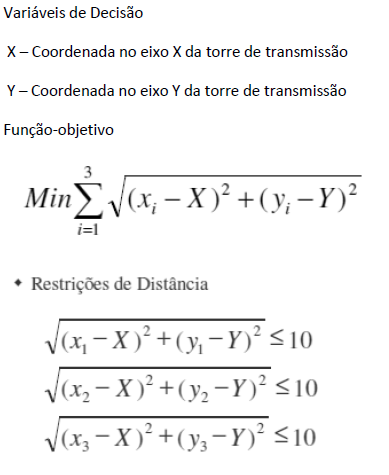

## Constantes do problema

In [ ]:
IND_SIZE=2                                  # quantidade de variaveis de decisao
LIMINF, LIMSUP = -200, 200                  # liminte das variaveis de decisao
DISTANCIA_MAXIMA = 10
CENTROS = np.array([[-5.,10.], [2.,1.], [10.,5.]])


## Preparação para Otimização


### 1. Função Objetivo

In [ ]:
# Função Objetivo
def objective_function(individual):
    x  = individual[0]
    y = individual[1]
    distancias = np.sqrt(np.sum((CENTROS - [x,y])**2, axis = 1))
    return (np.sum(distancias)),

### 2.   Penalização

In [ ]:
def feasible(individual):
    x  = individual[0]
    y = individual[1]
    distancias = np.sqrt(np.sum((CENTROS - [x,y])**2, axis = 1))
    
    for d in distancias:
        if d > DISTANCIA_MAXIMA:
            return False
    return True

def distance(individual):
    x  = individual[0]
    y = individual[1]
    distancias = np.sqrt(np.sum((CENTROS - [x,y])**2, axis = 1))
    return np.squeeze(np.sum(abs(distancias + DISTANCIA_MAXIMA)))

In [ ]:
def mutUniFloat(individual, low, up, indpb):
    """Mutate an individual by replacing attributes, with probability *indpb*,
    by a float uniformly drawn between *low* and *up* inclusively.

    :param individual: :term:`Sequence <sequence>` individual to be mutated.
    :param low: The lower bound or a :term:`python:sequence` of
                of lower bounds of the range from wich to draw the new
                integer.
    :param up: The upper bound or a :term:`python:sequence` of
               of upper bounds of the range from wich to draw the new
               integer.
    :param indpb: Independent probability for each attribute to be mutated.
    :returns: A tuple of one individual.
    """
    size = len(individual)
    if not isinstance(low, Sequence):
        low = repeat(low, size)
    elif len(low) < size:
        raise IndexError("low must be at least the size of individual: %d < %d" % (len(low), size))
    if not isinstance(up, Sequence):
        up = repeat(up, size)
    elif len(up) < size:
        raise IndexError("up must be at least the size of individual: %d < %d" % (len(up), size))

    for i, xl, xu in zip(range(size), low, up):
        if random.random() < indpb:
            individual[i] = (up-low)*(random.random()-.5)

    return individual,

### 3.   Indivíduos e Variáveis de Decisão

In [ ]:
creator.create("FitnessMin", base.Fitness  , weights=(-1.0,))         # função objetivo: <nome>, tipo(f.o.), peso de cada objetivo (no caso só um objetivo)
creator.create("Individual", list,  fitness=creator.FitnessMin)      # indivíduo

/usr/local/lib/python3.6/dist-packages/deap/creator.py:141: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)
/usr/local/lib/python3.6/dist-packages/deap/creator.py:141: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)


In [ ]:
toolbox = base.Toolbox()

# Gerador de atributos reais: nome, tipo das variáveis, intervalo (limites inferior e superior)
toolbox.register("attr_real", random.uniform , LIMINF, LIMSUP)   # variáveis inteiras

# Inicializador de indivíduo e população
toolbox.register("individual", tools.initRepeat, creator.Individual, toolbox.attr_real, IND_SIZE)   # 2: número de variáveis de decisão
toolbox.register("population", tools.initRepeat, list, toolbox.individual)                          # lista de indivíduos

### 4.   Operadores

In [ ]:
# Incializador de operadores
toolbox.register("evaluate", objective_function)                              # função objetivo
toolbox.decorate("evaluate", tools.DeltaPenalty(feasible, 0, distance))       
toolbox.register("mate", tools.cxSimulatedBinaryBounded, eta=.5, low=LIMINF, up=LIMSUP)
toolbox.register("mutate", tools.mutGaussian, mu=0, sigma=LIMSUP, indpb=0.05)
toolbox.register("select", tools.selTournament, tournsize=3)

## Criando população e hall da fama

In [ ]:
pop = toolbox.population(n=50)                            # inicialização da pop
hof = tools.HallOfFame(1)                                 # melhor indivíduo

## Definindo estatisticas desejáveis

In [ ]:
stats = tools.Statistics(lambda ind: ind.fitness.values)  # estatísticas
stats.register("avg", np.mean)
stats.register("std", np.std)
stats.register("min", np.min)
stats.register("max", np.max)

## Otimização

In [ ]:
pop, log = algorithms.eaSimple(pop, toolbox, cxpb=0.5, mutpb=0.1, ngen=400, stats=stats, halloffame=hof, verbose=True)

gen	nevals	avg    	std    	min    	max    
0  	50    	520.348	171.574	136.066	809.782
1  	23    	384.26 	140.913	127.2  	613.178
2  	25    	242.868	103.356	96.002 	447.685
3  	28    	166.098	60.5166	81.0457	336.26 
4  	31    	119.989	35.3891	72.7288	252.189
5  	29    	106.909	88.476 	52.7014	710.557
6  	23    	93.5083	60.4203	52.7014	415.713
7  	25    	75.6335	8.17709	52.0748	88.6565
8  	26    	72.5627	27.0013	52.0177	247.577
9  	25    	59.728 	9.96132	21.3692	80.8477
10 	30    	79.0885	194.482	21.305 	1438.18
11 	25    	42.9723	14.1126	20.8709	57.3735
12 	27    	55.8278	167.816	20.8644	1226.19
13 	27    	21.7797	4.32417	20.8644	52.0177
14 	30    	39.141 	111.006	20.7205	807.018
15 	26    	30.2871	65.9433	20.7172	491.89 
16 	32    	30.3467	56.2761	20.6656	416.218
17 	29    	20.7792	0.0765727	20.6415	20.879 
18 	34    	20.7337	0.0911879	20.4912	21.1125
19 	33    	20.6675	0.0636038	20.4775	20.7264
20 	30    	20.6223	0.0839853	20.4342	20.7756
21 	26    	23.8859	23.3829  	20.4342	187.565
2

## Resultados

In [ ]:
# Melhor solução
print("Melhor Localização da antena:")
print(hof[0])

# Melhor resultado da função objetivo
print("Melhor Resultado da Função Objetivo:")
np.squeeze(objective_function(hof[0]))

Melhor Localização da antena:
[2.577067156059233, 3.562892489020909]
Melhor Resultado da Função Objetivo:


array(20.13007227)

### Gráfico da evolução

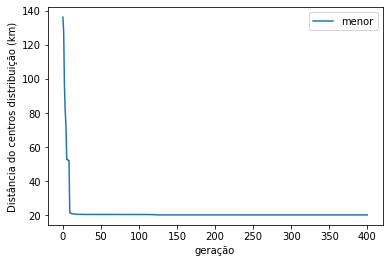

In [ ]:
gen, min = log.select('gen', 'min')
plt.plot(gen, min, label='menor')
plt.ylabel('Distância do centros distribuição (km)')
plt.xlabel('geração')
plt.legend();